In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms#, datasets
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Done")

Done


In [17]:
# Dataset and Annotations
input_directory = "..\\o_npy_resized" #244x244 npy files
annotations_path = "age_annotations.csv"

In [18]:
# Seed
torch.manual_seed(627726)

In [19]:
# Dataset Class
class AgeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[(self.annotations['Age'] != 0) & (self.annotations['Age'].notnull())] # removes rows where age is unknown
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = np.load(img_path)
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [20]:
# Create Dataset
dts = AgeDataset(csv_file=annotations_path, root_dir=input_directory, transform=transforms.ToTensor())

In [23]:
"""
# Get Min and Max
min_val = 1000.0
max_val = 0.0
avg_val = 0.0
total_val = 0.0
for i in dts:
    min_val = min(i[1].item(), min_val)
    max_val = max(i[1].item(), max_val)
    total_val += i[1].item()
avg_val = total_val/len(dts)
print(min_val)
print(max_val)
print(total_val)
print(avg_val)
"""

'\n# Get Min and Max\nmin_val = 1000.0\nmax_val = 0.0\navg_val = 0.0\ntotal_val = 0.0\nfor i in dts:\n    min_val = min(i[1].item(), min_val)\n    max_val = max(i[1].item(), max_val)\n    total_val += i[1].item()\navg_val = total_val/len(dts)\nprint(min_val)\nprint(max_val)\nprint(total_val)\nprint(avg_val)\n'

In [24]:
# Get Min and Max
"""
min_age = 1000.0
min_age_path = ""
max_age = 0.0
max_age_path = ""
for i in dts:
    if i[1] > max_age:
        max_age = i[1]
        max_age_path = i[2]
        print("new max: " + max_age_path)
    if i[1] < min_age:
        min_age = i[1]
        min_age_path = i[2]
        print("new min: " + min_age_path)

print(max_age)
print(max_age_path)
print(min_age)
print(min_age_path)
"""

'\nmin_age = 1000.0\nmin_age_path = ""\nmax_age = 0.0\nmax_age_path = ""\nfor i in dts:\n    if i[1] > max_age:\n        max_age = i[1]\n        max_age_path = i[2]\n        print("new max: " + max_age_path)\n    if i[1] < min_age:\n        min_age = i[1]\n        min_age_path = i[2]\n        print("new min: " + min_age_path)\n\nprint(max_age)\nprint(max_age_path)\nprint(min_age)\nprint(min_age_path)\n'

In [6]:
# Create Test and Train Data
train_size = int(len(dts) * 0.8)
test_size = len(dts) - train_size

train_data, test_data = torch.utils.data.random_split(dts, [train_size, test_size])

In [7]:
# Model Class
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)

        self.dp1 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(26*26*128, 1)

    def forward(self, X):
        # Basically what we did in the previous step
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)

        # Flatten Data
        # input is -1 to automatically infer batch size, this means we can have a varying batch size
        # output is the number of features
        X = X.view(-1, 26*26*128)

        # Dropout
        X = self.dp1(X)
        
        # FC Layers
        X = self.fc1(X)

        return X #F.log_softmax(X, dim=1)

In [12]:
# Create Model
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=86528, out_features=1, bias=True)
)

In [13]:
# Loss Function optimizer
criterion = nn.L1Loss() # MAE Loss for outliers
# lr is learning rate, smaller is slower but better, higher is faster but worse
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
import time
start_time = time.time()

# Define Tracking Vars
# Number of times to train and test
epochs = 8
train_losses = []
test_losses = []

# Train and Test Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Loop of Epochs
for i in range(epochs):
    model.train()

    # Train
    running_train_loss = 0.0
    for b,(X_train, y_train) in enumerate(train_loader):
        b += 1 #start batches at 1
        
        y_pred = model(X_train).squeeze()  # get predicted values from training set. 2D not flat
        loss = criterion(y_pred, y_train) # How wrong is the prediction

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track Loss
        running_train_loss += loss.item()

        # Print Results
        if b%10 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()} Time: {time.time() - start_time}")

    train_losses.append(running_train_loss/len(train_loader))
    print(f"Epoch: {i} Avg Loss: {running_train_loss/len(train_loader)} Time: {time.time() - start_time}")

    # Test
    # No gradient
    # Don't update weight or biases
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test).squeeze()

            # Track Loss
            loss = criterion(y_val, y_test)
            running_test_loss += loss.item()

        #loss = criterion(y_val, y_test)
        test_losses.append(running_test_loss/len(test_loader))


current_time = time.time()
total = current_time - start_time

print(f"Training Took: {total} seconds!")

Epoch: 0 Batch: 10 Loss: 22.120656967163086 Time: 5.6420934200286865
Epoch: 0 Batch: 20 Loss: 9.419528007507324 Time: 11.344509840011597
Epoch: 0 Batch: 30 Loss: 10.6806001663208 Time: 17.025186777114868
Epoch: 0 Batch: 40 Loss: 13.620420455932617 Time: 22.71313714981079
Epoch: 0 Batch: 50 Loss: 11.236467361450195 Time: 28.419490575790405
Epoch: 0 Batch: 60 Loss: 7.361139297485352 Time: 34.1225152015686
Epoch: 0 Batch: 70 Loss: 8.140727043151855 Time: 39.84815001487732
Epoch: 0 Batch: 80 Loss: 7.953033447265625 Time: 45.559226751327515
Epoch: 0 Batch: 90 Loss: 8.789117813110352 Time: 51.30779695510864
Epoch: 0 Batch: 100 Loss: 9.313365936279297 Time: 56.96055793762207
Epoch: 0 Batch: 110 Loss: 9.150919914245605 Time: 62.67598056793213
Epoch: 0 Batch: 120 Loss: 8.16657543182373 Time: 68.39257049560547
Epoch: 0 Batch: 130 Loss: 7.898207664489746 Time: 74.0993926525116
Epoch: 0 Batch: 140 Loss: 9.541618347167969 Time: 79.87467575073242
Epoch: 0 Batch: 150 Loss: 7.848494052886963 Time: 85.

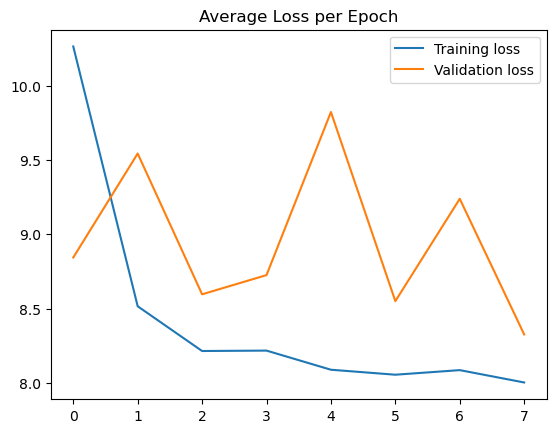

In [18]:
# Graphing
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Average Loss per Epoch")
plt.legend()
plt.savefig("age_estimation_finale.png")
plt.show()

In [19]:
# Save Loss Data
combined = np.column_stack((train_losses, test_losses))

# Save to CSV
np.savetxt("o_avg_loss.csv", combined, delimiter=",", header="Training Loss,Test Loss", comments='', fmt='%s')

In [37]:
# Grab an image
my_index = 123
test_data[my_index][1] # This is the label, ie it's classification
#test_data[my_index][0] # image in numpy format

tensor(41.)

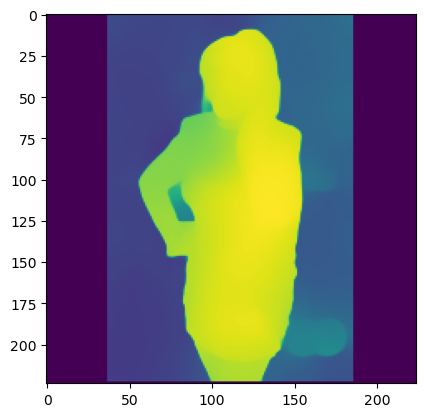

In [38]:
#Show image
plt.imshow(test_data[my_index][0].reshape(224,224))
plt.show()

In [39]:
# Evaluate Grabbed Datapoint
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[my_index][0].view(1,1,224,224)) # Batch size of 1, 1 channel, 28x28

new_prediction.item()

39.880043029785156

In [17]:
# Save Model
torch.save(model.state_dict(), "epochs_finale_8.pt")